# Common

In [1]:
#!pip install tqdm

In [48]:
import os, sys, subprocess
import json
import time
import pickle
import math
import numpy as np
import pandas as pd
from tqdm.contrib.concurrent import process_map
from tqdm.notebook import tqdm
tqdm.pandas()
import shutil
import urllib.parse
from matplotlib import pyplot as plt
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [3]:
current_path = os.getcwd()

In [4]:
def bracket_row(row):    
    s = row['data']
    index = min(s.find('.'), s.find('('))
    data = row['data']
    row['data'] = data[0:index]
    row['bracket'] = data[index:]
    return row

In [5]:
def adjust(text,n=7):
    text = str(text)    
    return " " * (n - len(text)) + text

In [6]:
def bracket_to_ct(tag, data, bracket, deltaG, negative_deltaG=True):    
    deltaG = deltaG.replace('(','').replace(')','')
    deltaG = float(deltaG)
    if(deltaG > 0 and negative_deltaG ): # negetive?!
        deltaG = -1 * deltaG
    stack = []
    index = np.zeros((len(bracket)), dtype = int)
    values = np.zeros((len(bracket)), dtype = int)
    for i in range(len(bracket)):
        index[i] = i + 1
        if(bracket[i] == '.'):
            values[i] = 0
        elif(bracket[i] == '('):
            stack.append(i)
        elif(bracket[i] == ')'):
            if(len(stack) == 0 ):
                print('structure error!')
            values[stack[-1]] = i + 1
            values[i]  = stack[-1] + 1
            stack.pop()
        else:
            print('structure error!')
    if(len(stack) != 0 ):
        print('structure error!')
    # body    
    ct = f"{adjust(len(data),6)} dG ={adjust(deltaG,10)} {tag}\n"   
    for i in range(len(bracket)):
        ct += f"{adjust(index[i],6)} {data[i]} {adjust(i,6)} {adjust((i+2)%(len(data)+1),6)} {adjust(values[i],6)} {adjust(index[i],7)}\n"
    return ct

In [7]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    tags = []
    data = []
    for l in lines:
        if(l[0]=='>'):
            tags.append(l)        
            data.append(s)
            s = ''
        else:
            s += l    
    data.append(s)
    df = pd.DataFrame(
            {
                'tag': tags,
                'data': data[1:]
            })
    df['tag'] = df['tag'].apply(lambda x: x[1:])    
    return df

In [8]:
def df_to_fasta(df, path):
    lines = []
    df.apply(lambda row: lines.append(f">{row['tag']}\n{row['data']}\n"),axis=1)
    with open(path,'w') as file:
        file.write(''.join(lines))

In [9]:
def reformat(path):
    return path.replace('(','_').replace(')','_').replace('.','').replace(':','_')

In [10]:
def reformatCT(path):
    with open(path, 'r') as file:
        text = file.read()
    text = [l for l in text.split('\n') if len(l) > 0 ] # remove blank lines
    text = '\n'.join(text)
    text = text.replace("\t"," ")
    while("  " in text):
        text = text.replace("  ", " ")
    lines = [l for l in text.split('\n')]
    for i in range(len(lines)):
        if(lines[i][0] == " "):
            lines[i] = lines[i][1:]
        if(lines[i][-1] == " "):
            lines[i] = lines[i][:-1]
    text = '\n'.join(lines)
    return text

In [11]:
def get_ct_data(ct):
    ct = "\n".join(ct.split('\n')[1:])
    df = pd.read_csv(StringIO(ct), sep=" ", header=None)               
    nucleotide = df.iloc[:,1]
    index = df.iloc[:,5]
    values = df.iloc[:,4]
    return [nucleotide, index, values]

In [12]:
def ct2dot_bracket(path):
    [nucleotide, index, values] = get_ct_data(reformatCT(path))
    text = ''.join(nucleotide) + "\n"
    watch = []
    for i, v in zip(index,values):
        if(v == 0):
            text += '.'
        else:
            if( v not in watch):
                text += '('
                watch.append(i)
            if( v in watch):
                text += ')'
    return text

In [13]:
def is_nested(index, values):
    max_value = max(index) + 10 # inf
    for i, v in zip(index, values):
        if(v < max_value and v != 0):
            max_value  = v
        if(i >= max_value):
            max_value = max(index) + 10 # inf
        if(v > max_value):
            return False               
    return True

# Mirbase

In [14]:
directory = '../data/miRBase'

In [15]:
mature = fasta_to_df(f'{directory}/mature.fa')
mature_high_conf = fasta_to_df(f'{directory}/mature_high_conf.fa')
mature['trim tag'] = mature['tag'].apply(lambda line: ' '.join(line.split(' ')[:2]))
mature['confidence'] = mature['trim tag'].isin(mature_high_conf['tag'])

In [16]:
mature['organism'] = mature['tag'].apply(lambda x: x[:3])
print(mature.shape)
mature.head(2)

(48885, 5)


,tag,data,trim tag,confidence,organism
0,cel-let-7-5p MIMAT0000001 Caenorhabditis elega...,UGAGGUAGUAGGUUGUAUAGUU,cel-let-7-5p MIMAT0000001,True,cel
1,cel-let-7-3p MIMAT0015091 Caenorhabditis elega...,CUAUGCAAUUUUCUACCUUACC,cel-let-7-3p MIMAT0015091,True,cel


In [17]:
organism = pd.read_csv(f'./{directory}/organisms.txt',sep='\t')
organism.columns = [c.replace('#','') for c in organism.columns] # remove sharp from columns
print(organism.shape)
organism.head(2)

(285, 5)


,organism,division,name,tree,NCBI-taxid
0,aqu,AQU,Amphimedon queenslandica,Metazoa;Porifera;,400682
1,nve,NVE,Nematostella vectensis,Metazoa;Cnidaria;,45351


In [18]:
items = list(organism['tree'].unique())
items.sort(key=len)
items

['Viruses;',
 'Mycetozoa;',
 'Alveolata;',
 'Metazoa;Porifera;',
 'Metazoa;Cnidaria;',
 'Viridiplantae;Chlorophyta;',
 'Viridiplantae;Embryophyta;',
 'Viridiplantae;Coniferophyta;',
 'Viridiplantae;Magnoliophyta;',
 'Metazoa;Bilateria;Deuterostoma;',
 'Chromalveolata;Heterokontophyta;',
 'Metazoa;Bilateria;Ecdysozoa;Nematoda;',
 'Metazoa;Bilateria;Lophotrochozoa;Annelida;',
 'Metazoa;Bilateria;Lophotrochozoa;Nemertea;',
 'Metazoa;Bilateria;Lophotrochozoa;Mollusca;',
 'Viridiplantae;Magnoliophyta;monocotyledons;',
 'Metazoa;Bilateria;Deuterostoma;Hemichordata;',
 'Metazoa;Bilateria;Deuterostoma;Echinodermata;',
 'Metazoa;Bilateria;Lophotrochozoa;Brachiopoda;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Hexapoda;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Crustacea;',
 'Metazoa;Bilateria;Lophotrochozoa;Platyhelminthes;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Chelicerata;',
 'Metazoa;Bilateria;Ecdysozoa;Arthropoda;Mandibulata;',
 'Viridiplantae;Magnoliophyta;eudicotyledons;Poaceae;',
 'M

In [19]:
selectedTree = organism[organism['tree'].apply(lambda x: "Viridiplantae;" in x)]
print(selectedTree.shape)
selectedTree.head(5)

(86, 5)


,organism,division,name,tree,NCBI-taxid
66,cre,CRE,Chlamydomonas reinhardtii,Viridiplantae;Chlorophyta;,3055
67,pta,PTA,Pinus taeda,Viridiplantae;Coniferophyta;,3352
68,ppt,PPT,Physcomitrella patens,Viridiplantae;Embryophyta;,3218
69,smo,SMO,Selaginella moellendorffii,Viridiplantae;Embryophyta;,88036
70,ath,ATH,Arabidopsis thaliana,Viridiplantae;Magnoliophyta;eudicotyledons;Bra...,3702


In [20]:
selected = mature[mature['organism'].isin(selectedTree['organism'])]
print(selected.shape)
selected.head(1)

(10414, 5)


,tag,data,trim tag,confidence,organism
316,ath-miR156a-5p MIMAT0000166 Arabidopsis thalia...,UGACAGAAGAGAGUGAGCAC,ath-miR156a-5p MIMAT0000166,False,ath


In [25]:
def isChar(c):
    return not c in [' ', '-', '|']

def adjust(text,n=7):
    text = str(text)    
    return " " * (n - len(text)) + text

def isMature(c1, c2):
    if(c1.isupper() and isChar(c1)):
        return True
    if(c2.isupper() and isChar(c2)):
        return True
    return False

def get_number(strText):
    number = 0 
    for i in range(len(strText[2])):
        if(isChar(strText[2][i]) or isChar(strText[3][i])):
            number += 1    
        if(isChar(strText[4][i])):
            number += 1    
        if(isChar(strText[5][i]) or isChar(strText[6][i])):
            number += 1     
    return number

def get5pInfo(strText):
    has_5p = False
    s_5p = 0
    f_5p = 0
    counter = 0
    for i in range(len(strText[2])):
        if(isChar(strText[2][i]) or isChar(strText[3][i])):
            counter += 1            
            if(isMature(strText[2][i] ,strText[3][i])):
                if(not has_5p):
                    has_5p = True
                    s_5p = counter
                else:
                    continue
            elif(has_5p):
                f_5p = counter - 1 
                break
    return [has_5p, s_5p, f_5p]

def get3pInfo(strText, number):
    has_3p = False
    s_3p = 0
    f_3p = 0
    counter = 0
    for i in range(len(strText[6])):
        if(isChar(strText[6][i]) or isChar(strText[5][i])):
            counter += 1            
            if(isMature(strText[6][i] ,strText[5][i])):
                if(not has_3p):
                    has_3p = True
                    s_3p = counter
                else:
                    continue
            elif(has_3p):
                f_3p = counter - 1 
                break        
    return [has_3p, number - f_3p + 1, number - s_3p + 1]    

def convertor(strText):
    index  = []
    values = []
    nucludid = []
    def add(i, v, n):        
        index.append(i)
        values.append(v)
        nucludid.append(n)
            
    f_counter = 1
    r_counter = 0
                    
    number = get_number(strText)    
    [FO, FI, Mid, RI, RO] = strText[2:]
    # main loop    
    for i in range(len(Mid)):           
        
        if(isChar(FO[i]) and FI[i] == " " and Mid[i] == " " and RI[i] == " "  and RO[i] == "-" ):
            add(f_counter, 0, FO[i])                
            f_counter += 1                      
                
        elif(FO[i] == "-" and FI[i] == " " and Mid[i] == " " and RI[i] == " "  and isChar(RO[i])):                                            
            add(number - r_counter, 0, RO[i])                
            r_counter += 1                      
        
        elif(isChar(FO[i]) and not isChar(FI[i]) and not isChar(Mid[i]) and not isChar(RI[i]) and isChar(RO[i])):
            add(f_counter, 0, FO[i])                    
            add(number - r_counter, 0, RO[i])                                
            f_counter += 1        
            r_counter += 1                              
            
        elif(not isChar(FO[i]) and isChar(FI[i]) and Mid[i] == "|" and isChar(RI[i]) and not isChar(RO[i])):        
            add(f_counter, number - r_counter, FI[i])                        
            add(number - r_counter, f_counter, RI[i])                
            f_counter += 1        
            r_counter += 1                  
            
        elif(not isChar(FO[i]) and isChar(FI[i]) and isChar(Mid[i]) and isChar(RI[i]) and not isChar(RO[i])):
            add(f_counter, 0, FI[i])
            add(f_counter + 1, 0, Mid[i])
            add(number - r_counter, 0, RI[i])
            f_counter += 2
            r_counter += 1
            
        elif(not isChar(FO[i]) and isChar(FI[i]) and Mid[i] == " " and isChar(RI[i]) and not isChar(RO[i])):                
            add(f_counter, 0, FI[i])                    
            add(number - r_counter, 0, RI[i])                    
            f_counter += 1        
            r_counter += 1                  
            
        elif(not isChar(FO[i]) and not isChar(FI[i]) and isChar(Mid[i]) and not isChar(RI[i]) and not isChar(RO[i])):                
            add(f_counter, 0, Mid[i])                                
            f_counter += 1                    

    # sort indexs and other base on indexes
    inds = np.array(index).argsort()    
    nucludid = np.array(nucludid)[inds]       
    return ''.join(nucludid)

In [31]:
with open(f'./{directory}/miRNA.str') as file:
    strRNA = file.read()
    lines = strRNA.split('\n')
nuclutide = []
hit_start = []
hit_end = []
tags = []
for i in tqdm(range(0,len(lines), 8)):
    tag = lines[i]    
    if(True):                
        strText = lines[i:(i+7)]        
        if(len(strText) == 7):
            nuc = convertor(strText).lower()            
            number = get_number(strText)    
            [has_5p, s_5p, f_5p] = get5pInfo(strText)                
            [has_3p, s_3p, f_3p] = get3pInfo(strText, number)
            if(has_5p):
                if(s_5p > f_5p):                    
                    continue
            if(has_3p):
                if(s_3p > f_3p):                    
                    continue
            if(has_5p):
                nuclutide.append(nuc)
                hit_start.append(s_5p)                
                hit_end.append(f_5p)
                tags.append(tag[1:4] )
            if(has_3p):
                nuclutide.append(nuc)                
                hit_start.append(s_3p)
                hit_end.append(f_3p)  
                tags.append(tag[1:4] )
precursor = pd.DataFrame({"tag":tags, "data": nuclutide, "hit_start": hit_start, "hit_end": hit_end})
precursor = precursor[precursor['tag'].isin(selectedTree['organism'])]
precursor['len'] = precursor['data'].apply(lambda x: len(x))

  0%|          | 0/38590 [00:00<?, ?it/s]

In [39]:
precursor['hit'] = precursor.apply(lambda row: row['data'][(row['hit_start']-1):(row['hit_end'])].upper(), axis=1)
precursor['confidence'] = precursor['hit'].apply(lambda hit: selected['confidence'][selected['data'] == hit].sum() > 0)
precursor['tag'] = precursor.index
print(precursor.shape)
precursor.head()

<ipython-input-39-3014fc0e4c56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precursor['hit'] = precursor.apply(lambda row: row['data'][(row['hit_start']-1):(row['hit_end'])].upper(), axis=1)


(10288, 6)


<ipython-input-39-3014fc0e4c56>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precursor['confidence'] = precursor['hit'].apply(lambda hit: selected['confidence'][selected['data'] == hit].sum() > 0)
<ipython-input-39-3014fc0e4c56>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precursor['tag'] = precursor.index


,tag,data,hit_start,hit_end,hit,confidence
333,333,caagagaaacgcaaagaaacugacagaagagagugagcacacaaag...,21,40,UGACAGAAGAGAGUGAGCAC,True
334,334,caagagaaacgcaaagaaacugacagaagagagugagcacacaaag...,83,104,GCUCACUGCUCUUUCUGUCAGA,True
335,335,gcuagaagagggagagauggugauugaggaaugcaacagagaaaac...,47,66,UGACAGAAGAGAGUGAGCAC,True
336,336,gcuagaagagggagagauggugauugaggaaugcaacagagaaaac...,106,128,UGCUCACCUCUCUUUCUGUCAGU,False
337,337,cgcauagaaacugacagaagagagugagcacacaaaggcacuuugc...,12,31,UGACAGAAGAGAGUGAGCAC,True


# for totoal length

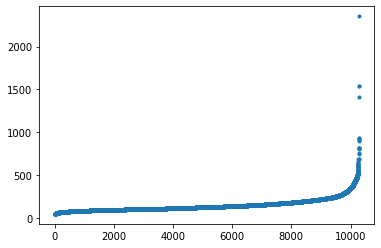

In [49]:
plt.plot(sorted(precursor['len']), ".")

In [54]:
((precursor['len'] > 400).sum() / precursor['len'].shape[0]) * 100 

1.7884914463452566

In [71]:
length = sorted(precursor['len'])
number = len(length)
for cut in [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]:
    print(f'for {cut * 100}% set length: {length[int(number * cut)]}')

for 90.0% set length: 233
for 91.0% set length: 239
for 92.0% set length: 249
for 93.0% set length: 258
for 94.0% set length: 271
for 95.0% set length: 289
for 96.0% set length: 311
for 97.0% set length: 346
for 98.0% set length: 382
for 99.0% set length: 453


# for downstream & upstream

In [81]:
precursor['down_stream'] = precursor['hit_start'] - 1 
precursor['up_stream'] = precursor['len'] - precursor['hit_end']

<ipython-input-81-4be6505a4755>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precursor['down_stream'] = precursor['hit_start'] - 1
<ipython-input-81-4be6505a4755>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precursor['up_stream'] = precursor['len'] - precursor['hit_end']


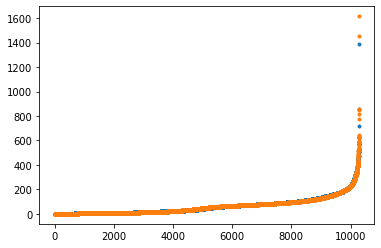

In [83]:
plt.plot(sorted(precursor['down_stream']), ".")
plt.plot(sorted(precursor['up_stream']), ".")

In [84]:
down_stream = sorted(precursor['down_stream'])
up_stream = sorted(precursor['up_stream'])

In [86]:
number = len(down_stream)
print("down_stream")
for cut in [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]:    
    print(f'for {cut * 100}% set length: {down_stream[int(number * cut)]}')

down_stream
for 90.0% set length: 150
for 91.0% set length: 155
for 92.0% set length: 161
for 93.0% set length: 168
for 94.0% set length: 176
for 95.0% set length: 188
for 96.0% set length: 203
for 97.0% set length: 222
for 98.0% set length: 255
for 99.0% set length: 331


In [87]:
number = len(up_stream)
print("up_stream")
for cut in [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]:    
    print(f'for {cut * 100}% set length: {up_stream[int(number * cut)]}')

up_stream
for 90.0% set length: 143
for 91.0% set length: 150
for 92.0% set length: 158
for 93.0% set length: 168
for 94.0% set length: 178
for 95.0% set length: 189
for 96.0% set length: 203
for 97.0% set length: 224
for 98.0% set length: 253
for 99.0% set length: 319
